# Инструкция по загрузке данных и удобной работе с ними

Для начала импортируем файл с классом для загрузки данных.

Вместе с ним импортируются все необходимые для работы библиотеки.

In [3]:
import sys
sys.path.insert(0, 'basic_codes')

import class_magnesium_not_drop_na #_transform_pairings
from class_magnesium_not_drop_na import *

### Прописываем пути до файлов

In [4]:
fold = '/home/david/Documents/3_grade/6_sem/machine_learning/homeworks/4/'
file_train = 'train.csv'
file_test = 'test.csv'

### Функция для обновления класса
Если вы что-то изменили в class_magnesium_not_drop_na.py, но не хотите перезагружать ядро(чтобы не потерять какие-либо данные), воспользуйтесь этой ячейкой.

In [7]:
import importlib
importlib.reload(class_magnesium_not_drop_na)
from class_magnesium_not_drop_na import *

### Инициируем класс 

In [11]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)

In [ ]:
#import xgboost
#model = 

In [2]:
'''
    Класс Magnesium загружает данные из файла file_, находящегося в папке fold. Делает dropna (чтобы кас не ругался)
    model - модель, с которой вы хотите работатьб по умолчанию RFC
    Сохраняет переменные:
    data - загруженный DataFrame
    features - признаки
    groups - цепочки
    x - данные для бучения в виде Numpy-матрицы
    y - целевой признак
'''
m = Magnesium(file_train, fold = fold, model = model)   # Можно написать любую свою модель

NameError: name 'Magnesium' is not defined

In [1]:
# P.s. эта ячейка порождает много графиков, чтобы не пришлось их скроллить Cell -> Current Outputs -> Toggle Scrolling
'''
  fit_predict осуществляет кроссвалидацию по следуюещему пайплайну:
            если with_groups = True делит выборку с помощью GroupShuffleSplit,
            если False - StratifiedShuffleSplit. 
            C биологической точки зрения логичнее делать разбиения с учетом групп, 
            так как группами являются цепочки => хорошо иметь данные всей цепочки в трейне.
  n_splits, test_size - параметры, окторые передаются GroupShuffleSplit или StratifiedShuffleSplit
  model - можете написать любую свою модель, по дефолту будет брать ту, которая была заложена при создании класса.
  plots - рисовать графики (ROC-AUC, precision-recall, confusion matrix, probability-densities) или нет
  plot_splits - для каких разбиений рисовать графики (разиения нумеруются с 0). По дефолту рисуется для последнего разюиения.
  x , y  - при желании можете подставить свои данные для кросс валидации. По дефолту берет загруженную выборку.
  
  Возвращает словарь с ключами:
  'test score', 'train score' - f1_score на всех сплитах
  'roc_auc': данные функции sklearn.metrics.roc_curve(y_test, y_prob)
  'prec_rec':[precision, recall, average_precision_score, prec_recall_plot]
  'confusion': [cnf_matrix, cnf_normed, cnf_plot, cnf_normed_plot] (normed - означает нормированная матрица)
  'plots':{'roc_auc', 'prec_recall', 'cnf_normed', 'cnf', 'prob_density'}
'''
data = m.fit_predict(n_splits = 5, plot_splits = [0,3]);

NameError: name 'm' is not defined

In [14]:
def load_data(filename):
    '''
        Функция для загрузки датасета без инициализации класса. 
        
        Возвращает:
         data - полный DataFrame
         fetures - список признаков для обучения/предсказания
         x - датасет для тренировки/предсказания в формате np.array
         y - целевой признак, если он есть. В случае с тестовым датасетом возвращает None
    '''
    
    data = pd.read_table(filename, sep=',').dropna()    
    
    data = data[~(data['chainlen']>1000)]

    if ('DSSR' in data.columns):
        data.drop('DSSR', axis=1, inplace=True)    
    
    features = list(deepcopy(data.columns))
    [features.remove(column) for column in ['Id','index', 'pdb_chain', 'mg'] if column in data.columns];
    x_test = np.array(data[features])
    
    try:
        y_test = np.array(data['mg'])
    except: 
        y_test = None
    change_output('Data loaded')
    return {'data':data, 'features':features, 'x':x_test, 'y':y_test}

In [15]:
test = load_data(fold+file_test)

Data loaded

### Тренируем модель на тренировочном датасете

In [16]:
m.trained_model = deepcopy(m.model)
m.trained_model.fit(m.x, m.y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

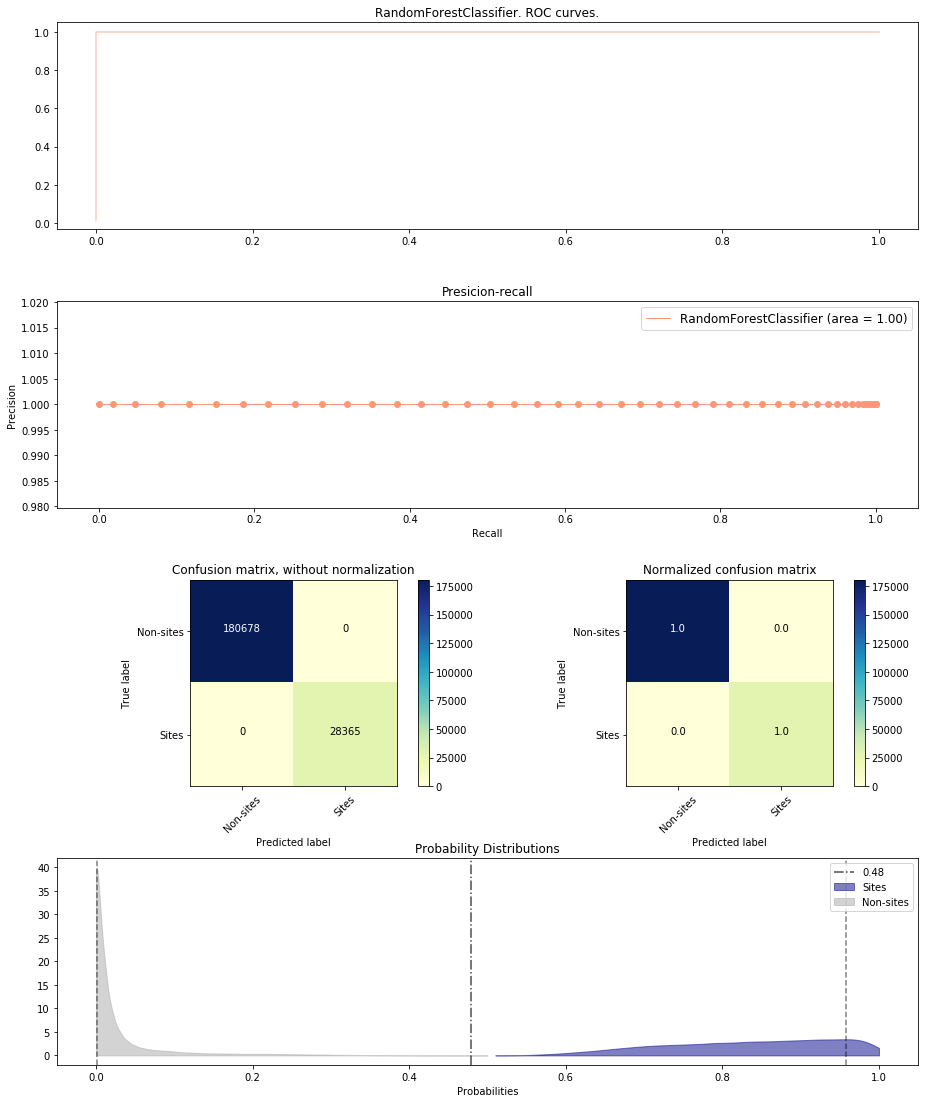

In [17]:
'''
   фунцкия класса Magnesium predict позволяет предказать с помощью натренированной модели 
   (по дефолту она берется из класса, но можно передать и извне в параметре model) на данных x, y;
   Оценить качество предсказания и построить графики. 
   Вовзращает словарь, аналогичный fit_predict.
   И по умолчанию рисует графики метрик качества, аналогичные fit_predict.
   
   Ecли y == None, все оценки качества и графики имеют значения None.
'''
predict_train =  m.predict(x = m.x, 
                           y = m.y,
                           model=m.trained_model, 
                           plots = True)
predict_test =  m.predict(x = test['x'], 
                          y = test['y'],
                          model=m.trained_model,
                          plots = False)

### Примечание

Для того, чтобы графики можно было строить в каком угодно порядке и комбинировать с другими, каждый график сохранется как список строк. Чтобы построить его, используйте функцию plot_one_plot. (P.s. она написана в файле с классом, продублирую ее здесь)

In [18]:
def plot_one_plot(plot_elements):
    [eval(plot_string) for plot_string in plot_elements]

Пример ее использования:

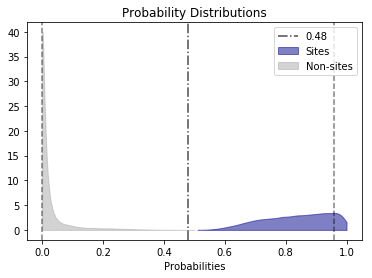

In [19]:
plot_one_plot(predict_train['plots']['prob_density'])